In [109]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import statsmodels.graphics.tsaplots
from scipy import stats

In [2]:
sns.set(style='whitegrid', palette="Set2", color_codes=True)
%matplotlib inline

In [3]:
Project_Dir = os.getcwd()
Processed_Data_Dir = Project_Dir + r"/Processed_Data"

In [4]:
DATA_UNDLY=pd.read_csv(Processed_Data_Dir+'/Underlyings.csv',usecols=np.arange(1,6),parse_dates=['Date'])

In [5]:
DATA_UNDLY.shape

(4938, 5)

In [6]:
DATA_UNDLY.head()

,Date,Close,Fig,Ten_ma,pct_chg
0,2015-08-20,287.5,GASL,355.7,-0.066558
1,2015-08-21,261.5,GASL,350.3,-0.090435
2,2015-08-24,216.0,GASL,332.7,-0.173996
3,2015-08-25,205.5,GASL,316.1,-0.048611
4,2015-08-26,227.0,GASL,296.7,0.104623


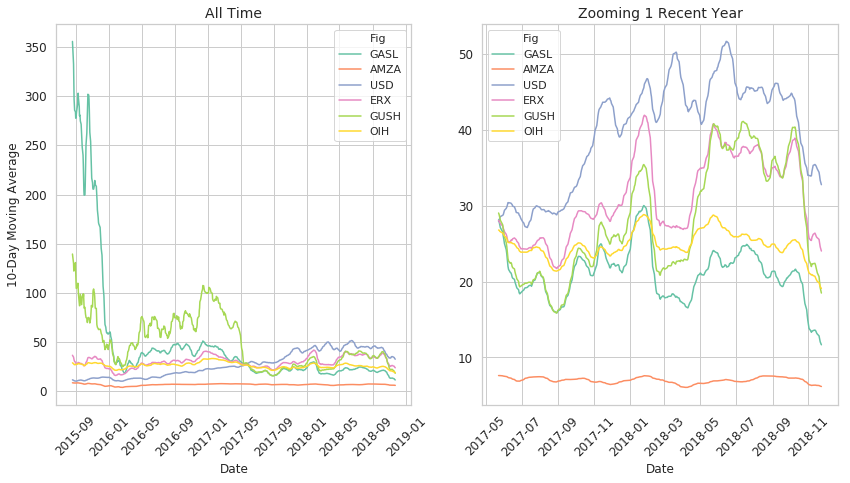

In [98]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
sns.lineplot(data=DATA_UNDLY,hue='Fig',y='Ten_ma',x='Date',ax=ax[0])
ax[0].tick_params(axis='x', rotation=45)
ax[0].set(ylabel='10-Day Moving Average',title='All Time')

sns.lineplot(data=DATA_UNDLY[DATA_UNDLY.Date>="2017-5-23"],hue='Fig',y='Ten_ma',x='Date',ax=ax[1])
ax[1].tick_params(axis='x', rotation=45)
ax[1].set(ylabel='',title='Zooming 1 Recent Year')
for ax in ax:
    for item in ([ax.yaxis.label,ax.xaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)
#     ax.set(title='Suggested Weight Adjustment For KAM\'s Features\n')
    # ax.xaxis.label.set_fontsize(13)
    ax.title.set_fontsize(14)
# plt.show()

In [99]:
dt_undly=DATA_UNDLY.loc[DATA_UNDLY.Date>="2017-5-23"]

* Get Rid of underlyings with low volatility

* Vecotrize Prices w.r.t each Underlying

In [100]:
data_close_pvt=dt_undly[['Date','Close','Fig']].pivot(index='Date',columns='Fig')
data_close_pvt.columns=data_close_pvt.columns.droplevel(0)

In [101]:
data_close_pvt.head().round(2)

Fig,AMZA,ERX,GASL,GUSH,OIH,USD
Date,,,,,,
2017-05-23,7.66,28.25,27.89,28.92,27.03,28.66
2017-05-24,7.63,27.86,26.63,27.88,26.77,29.06
2017-05-25,7.58,26.32,24.91,25.62,25.45,29.41
2017-05-26,7.55,26.36,25.15,25.84,25.59,29.67
2017-05-30,7.40,25.37,23.08,23.64,25.13,29.86


# Test GBM's Assumption 

### Auto Correlation

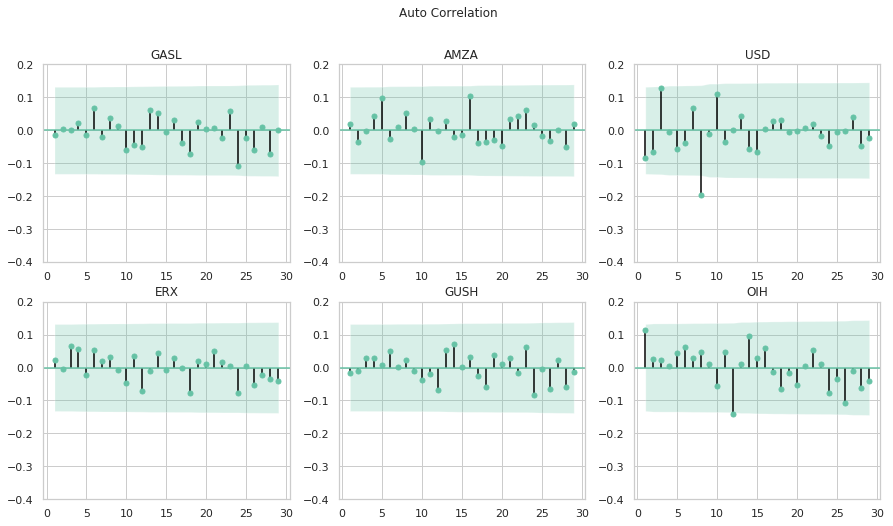

In [126]:
nrow,ncol,ax_ind=2, 3,0
fig = plt.figure(figsize=(15, 8))
fig.suptitle('Auto Correlation')
gs1 = gridspec.GridSpec(nrow,ncol)
ax_ls = [fig.add_subplot(ss) for ss in gs1]
for fig in dt_undly.Fig.unique():
    ax=ax_ls[ax_ind]
    statsmodels.graphics.tsaplots.plot_acf(x=dt_undly[dt_undly.Fig==fig].pct_chg,unbiased=False, lags=np.arange(1,30)
                                           ,alpha=0.01,ax=ax)
    ax.set(title=fig,ylim=(-0.4,0.2))
    ax_ind+=1

In [131]:
col_indept=['GASL', 'AMZA', 'USD', 'ERX', 'GUSH', 'OIH']

# Generate Underlying Price 

### Assumptions and Preparations

* (Projection) Sample Path Span, Based on Options Availability

In [132]:
DATA_OPT=pd.read_csv(Processed_Data_Dir+'/Options.csv',index_col=[0],parse_dates=['Maturity','D2M'])

DATA_OPT.D2M=pd.to_timedelta(DATA_OPT.D2M)

In [133]:
DATA_OPT.head()

,Maturity,Fig,Strike,Ask_p,D2M
0,2018-12-21,GASL,1.0,0.55,28 days
1,2018-12-21,GASL,2.0,0.55,28 days
2,2018-12-21,GASL,3.0,0.55,28 days
3,2018-12-21,GASL,4.0,0.55,28 days
4,2018-12-21,GASL,5.0,0.75,28 days


In [134]:
DATA_OPT.loc[DATA_OPT.Fig.isin(col_indept)].groupby(['D2M','Fig'],group_keys=False).agg({'Fig':'count'})

Fig
D2M      Fig      
14 days  ERX    16
         OIH    11
21 days  ERX    16
         OIH    12
25 days  GUSH    1
28 days  AMZA    6
         ERX    16
         GASL    9
         GUSH    6
         OIH    13
         USD    10
35 days  ERX    15
         OIH    11
42 days  ERX    17
         OIH    10
49 days  ERX    16
         OIH    10
56 days  AMZA    6
         ERX     4
         GASL    8
         GUSH    8
         OIH     9
         USD    15
84 days  ERX    11
         GASL    8
         GUSH    7
         USD    12
112 days AMZA    6
         GASL    7
         GUSH    3
146 days ERX     7
         OIH    10
175 days USD     7
210 days GUSH    3
420 days GUSH    3
784 days GUSH    3

* Make an Assumption on Projection Span

In [135]:
Gen_Span=pd.Timedelta(56,'D')

In [136]:
dt_option=DATA_OPT[DATA_OPT.D2M<=Gen_Span]

In [137]:
dt_option.shape,dt_option.columns

((245, 5),
 Index(['Maturity', 'Fig', 'Strike', 'Ask_p', 'D2M'], dtype='object'))

* Historical Growth rate Vector for each Underlying

In [141]:
dt_gamma=data_close_pvt.pct_change()
dt_gamma.head()

Fig,AMZA,ERX,GASL,GUSH,OIH,USD
Date,,,,,,
2017-05-23,NaN,NaN,NaN,NaN,NaN,NaN
2017-05-24,-0.003806,-0.013884,-0.045177,-0.035949,-0.009712,0.013876
2017-05-25,-0.006686,-0.055262,-0.064589,-0.081033,-0.049037,0.012203
2017-05-26,-0.003846,0.001490,0.009635,0.008584,0.005348,0.008789
2017-05-30,-0.020270,-0.037203,-0.082306,-0.085106,-0.017857,0.006478


* Hostory Rerence Span, Mean, Cov, nTrial

In [142]:
nTrial=10000
Gen_Mean,Gen_Cov=dt_gamma.mean(),dt_gamma.cov()

In [143]:
Gen_Mean,Gen_Cov

(Fig
 AMZA   -0.000556
 ERX    -0.000145
 GASL   -0.001505
 GUSH   -0.000238
 OIH    -0.000898
 USD     0.000687
 dtype: float64,
 Fig       AMZA       ERX      GASL      GUSH       OIH       USD
 Fig                                                             
 AMZA  0.000210  0.000325  0.000494  0.000512  0.000147  0.000157
 ERX   0.000325  0.001167  0.001441  0.001646  0.000517  0.000427
 GASL  0.000494  0.001441  0.002334  0.002483  0.000694  0.000533
 GUSH  0.000512  0.001646  0.002483  0.002804  0.000783  0.000593
 OIH   0.000147  0.000517  0.000694  0.000783  0.000287  0.000166
 USD   0.000157  0.000427  0.000533  0.000593  0.000166  0.000947)

### Simulate Underlyings, GBM

* Multinormal Growth Matrix,-sim_gamma

In [144]:
sim_gamma=np.random.multivariate_normal(mean=Gen_Mean,cov=Gen_Cov,size=(nTrial,Gen_Span.days))

In [145]:
sim_gamma.shape

(10000, 56, 6)

In [146]:
sim_gamma=dict(zip(dt_gamma.columns.tolist(),[sim_gamma[:,:,fig] for fig in range(sim_gamma.shape[2])]))

In [147]:
sim_gamma['GUSH'].shape

(10000, 56)

In [148]:
sim_gamma

{'AMZA': array([[ 0.00261149,  0.01040666, -0.01597546, ...,  0.01267463,
         -0.01039016, -0.0198025 ],
        [ 0.01388027,  0.00103103, -0.00122334, ...,  0.00198149,
          0.00669987, -0.01944841],
        [-0.0049539 ,  0.00615286,  0.00027216, ...,  0.01770236,
         -0.0158104 , -0.00255748],
        ...,
        [-0.00438696, -0.01186342, -0.0022067 , ...,  0.02005304,
         -0.02539054,  0.01428662],
        [-0.01001156, -0.00361684, -0.00196523, ...,  0.01973256,
         -0.00389391, -0.01126109],
        [ 0.0285512 , -0.02174946, -0.0157323 , ...,  0.01748758,
          0.00500638,  0.01410304]]),
 'ERX': array([[-0.04779872, -0.03320034, -0.04835181, ..., -0.00369663,
          0.04565985, -0.01296555],
        [-0.01062322, -0.00385269, -0.05325697, ...,  0.00972404,
         -0.02492656,  0.0139456 ],
        [ 0.01024331,  0.01526898,  0.01987097, ...,  0.01319925,
         -0.01484412, -0.0032989 ],
        ...,
        [ 0.00625406,  0.00228631, -0.0

In [149]:
sim_undly={}
sim_factor={}
for key,val in sim_gamma.items():
    sim_factor[key]=(val+1)
    s0=data_close_pvt[key][-1]
    cum_g=sim_factor[key].cumprod(axis=1)
    sim_undly[key]=s0*cum_g

In [150]:
class sim_result:
    def __init__(self, sim_undly):
        self.underlying=sim_undly
        self.max=sim_undly[list(sim_undly.keys())[0]].shape[0]
    def __iter__(self):
        self.n = 0
        return self

    def __next__(self):
        if self.n <= self.max:
            sim_undly0={}
            for key,val in self.underlying.items():
                sim_undly0[key]=val[self.n]
            sim_undly0=pd.DataFrame(sim_undly0)
            sim_undly0_longform=sim_undly0.reset_index().melt(id_vars=['index'],var_name='fig',value_name='close')
            fig, ax = plt.subplots(1, 1, figsize=(10, 5))
            sns.lineplot(data=sim_undly0_longform,hue='fig',y='close',x='index')
            self.n += 1
            print(self.n)
        else:
            raise StopIteration

In [151]:
sim_iter=iter(sim_result(sim_undly))

18


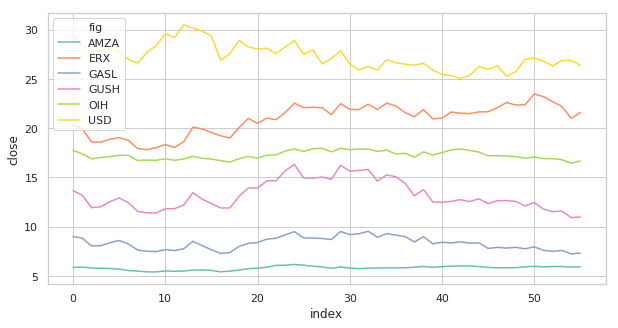

In [169]:
next(sim_iter)

# Appendix

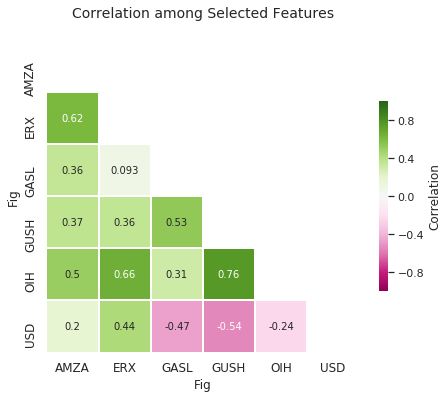

In [35]:
corr=data_close_pvt.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(7, 7))
with sns.axes_style(style='white'):
    ax = sns.heatmap(corr, mask=mask, vmin=-1, vmax=1,
                     square=True,
#                      xticklabels=labs_heatmap_x,
#                      yticklabels=labs_heatmap_y,
                     center=0,
                     annot=True,
                     # ax=ax,
                     cmap="PiYG",
                     linewidths=.5,
                     cbar_kws={"shrink": .5,
                               'label': 'Correlation'
                               }
                     )
for item in ([ax.yaxis.label,ax.xaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)
ax.set(title='Correlation among Selected Features\n')
ax.title.set_fontsize(14)
plt.show()


In [36]:
data_chg_pvt=data[['Date','pct_chg','Fig']].pivot(index='Date',columns='Fig')
data_chg_pvt.columns=data_chg_pvt.columns.droplevel(0)

NameError: name 'data' is not defined

In [ ]:
data_chg_pvt.head().round(3)

In [ ]:
data_chg_pvt.describe()[1:3]

In [ ]:
def sim_NTL(mu,cov,NTR):
    result=[]
    for n in range(NTR):    
        z_sim=np.column_stack([np.random.multivariate_normal(1+mu,cov,24),[1.0085]*24])    
        result.append(np.append(z_sim.prod(0),
                                [z_sim.prod(0).mean(),z_sim.mean(1).prod()])*100)
    return result